In [70]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy as copy
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [274]:
def load_joke(file):
    f = open(file,'r')
    
    data = []
    ind = 0
    for line in f:
        converted_line = ([np.float(i) for i in list(line.strip('\n').strip('').split(','))])
        data.append(converted_line)

    data = np.array(data)
    f.close()
    return data

def convert_jokes_matrix(data):
    users = np.unique(data[:,0]).astype(int) - 1
    num_people = np.max(users) + 1

    jokes = np.unique(data[:,1]).astype(int) - 1
    num_jokes = np.max(jokes) + 1

    R_matrix = np.zeros((num_people,num_jokes))
    R_matrix = np.nan*R_matrix

    for i in np.arange(data.shape[0]):
        R_matrix[int(data[i,0])-1,int(data[i,1])-1] = data[i,2]
        
    return R_matrix,users,jokes



def mean_square_error(predict,test):
    #num_entries = test.shape[0]*test.shape[1]
    num_entries =np.sum(np.sum(~np.isnan(test),axis=1))
    diff_predict_test = (predict - test)**2 
    error = (1/num_entries)*np.nansum(np.nansum(diff_predict_test))
    return error

def mean_absolute_error(predict,test):
    num_users = test.shape[0]
    num_test_moves_peruser = np.sum(~np.isnan(test),axis=1)
    diff_predict_test = np.abs(predict - test)
    
    movies_by_user_sum = np.nansum(diff_predict_test,axis=1)
    movies_by_user_weighted = 1/num_test_moves_peruser * movies_by_user_sum 
    
    error = (1/num_users) * np.sum(movies_by_user_weighted)
    return error

### load in the data from the .txt files

In [104]:
training = load_joke('./jester/train.txt')
testing = load_joke('./jester/test.txt')

### convert it to matrix form

In [107]:
training_R,users,jokes = convert_jokes_matrix(training)
testing_R,_,_ = convert_jokes_matrix(testing)

### perform prediction via average 

In [275]:
training_R_zeros = copy.copy(training_R)
training_R_zeros[np.isnan(training_R_zeros)] = 0

testing_R_zeros = copy.copy(testing_R)
testing_R_zeros[np.isnan(testing_R_zeros)] = 0

users_ones = np.ones((users.shape[0],1))
movie_averaged = np.nanmean(training_R,axis=0)

movie_averaged = np.expand_dims(movie_averaged,axis=1)

R_ij_predict = np.dot(users_ones,movie_averaged.T)

training_user_average = np.nanmean(training_R,axis=1)
training_R_no_user_avg = (training_R.T - training_user_average).T

#R_ij_predict = (R_ij_predict.T + training_user_average).T


array([-8.5,  nan,  nan, ...,  nan,  nan,  nan])

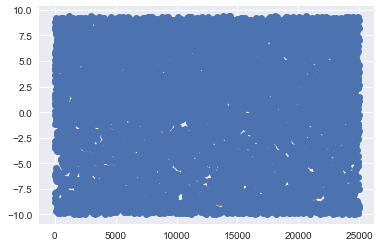

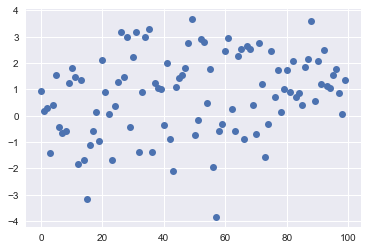

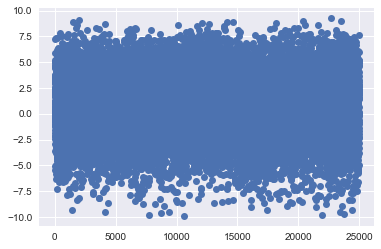

In [272]:
training_R[:,5]
plt.plot(training_R[:,1],'o')
plt.figure()
plt.plot(movie_averaged,'o')
plt.figure()
plt.plot(training_user_average,'o')

In [276]:
mse = mean_square_error(R_ij_predict,testing_R)
print('The mean squared error for using the average score for prediction on the test set is {:.2f}'.format(mse))

mae = mean_absolute_error(R_ij_predict,testing_R)
print('The mean absolute error for using the average score for prediction on the test set is {:.2f}'.format(mae))

mse = mean_square_error(R_ij_predict,training_R)
print('The mean squared error for using the average score for prediction on the train set is {:.2f}'.format(mse))

mae = mean_absolute_error(R_ij_predict,training_R)
print('The mean absolute error for using the average score for prediction on the train set is {:.2f}'.format(mae))

> <ipython-input-274-bb5c0287fb9a>(37)mean_square_error()
-> return error
(Pdb) num_entries
905756
(Pdb) predict-test
array([[ 8.75617795,         nan,  9.96791641, ...,         nan,
                nan,         nan],
       [-3.14382205,         nan, -6.05208359, ...,         nan,
                nan,  0.27288118],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ..., 
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-1.49382205,         nan,  4.28791641, ...,         nan,
                nan,         nan]])
(Pdb) (predict-test)**2
array([[  7.66706523e+01,              nan,   9.93593576e+01, ...,
                     nan,              nan,              nan],
       [  9.88361707e+00,              nan,   3.66277157e+01, ...,
                     nan,              nan,   7

BdbQuit: 

### averaging part 

In [57]:
users_ones = np.ones((users.shape[0],1))

movie_averaged = np.mean(training_R_no_user_avg,axis=0)

movie_averaged = np.expand_dims(movie_averaged,axis=1)


R_ij_predict = np.dot(users_ones,movie_averaged.T)

prediction = (R_ij_predict.T + training_user_average).T

prediction[0,:]

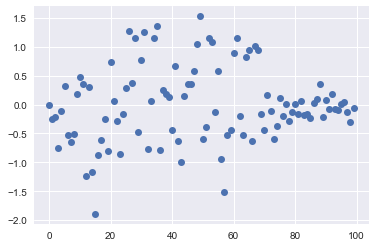

In [62]:
plt.plot(np.arange(len(movie_averaged)),movie_averaged,'o')
plt.plot

### SVD 

In [254]:
user_averaged[index]

array([-9.88970588])

In [265]:
np.nansum(R_ij_predict[index+1,:] - testing_R[index+1,:])

-9.5903412086441371

In [266]:
np.nansum(R_ij_predict[index,:] - testing_R[index,:])

0.19829994677470175

In [267]:
np.nansum(R_ij_predict[index-1,:] - testing_R[index-1,:])

28.628222362050458

In [268]:
R_ij_predict[index-1,:]

array([ 5.06915364,  4.77938468,  5.31649907,  5.26304597,  5.33968565,
        5.51617189,  5.35599403,  5.90451832,  5.39544094,  5.44023915,
        5.45795912,  5.51708551,  5.44994295,  5.61140166,  5.21793774,
        6.83264906,  5.44292703,  5.30789488,  5.73275555,  6.93366703,
        5.68684014,  5.73707478,  5.46892364,  5.58333094,  5.39225848,
        5.55151966,  5.71406651,  5.30399925,  4.86732329,  5.49474719,
        5.62092511,  4.96223101,  5.22182702,  5.71039595,  5.03532928,
        5.10742878,  5.00755571,  5.35655349,  5.49298959,  5.36943738,
        5.5645072 ,  5.49380365,  5.45350351,  5.16782379,  5.34801176,
        6.13637895,  5.35064326,  5.34038219,  5.31524416,  5.07355275,
        5.74399428,  5.69760379,  4.61372417,  5.48887417,  5.68470825,
        5.21252238,  5.33485656,  5.30852305,  5.28375709,  5.29364748,
        5.49603932,  5.02902228,  5.15185474,  5.4861492 ,  6.05587755,
        5.20549834,  5.63284774,  4.92518059,  5.05845672,  5.49

In [269]:
testing_R[index-1,:]

array([  nan,   nan,   nan,   nan,  6.75,   nan,  6.75,  8.01,   nan,
         nan,  6.89,   nan, -0.44,  6.21, -8.11,   nan,  2.91,  6.75,
         nan,   nan,   nan,   nan,   nan,   nan,  3.2 , -5.29,  5.78,
         nan,  4.51,   nan,   nan,   nan,   nan,   nan,  4.9 ,   nan,
         nan,   nan,   nan,   nan,   nan,  6.36,   nan,   nan,   nan,
         nan,   nan,  5.78,  6.41,  4.22,   nan,   nan,  7.82,  5.34,
         nan,   nan,  4.95,   nan,   nan,   nan,  7.77,   nan,   nan,
         nan,   nan,   nan,   nan,  4.81,   nan,   nan,   nan,   nan,
         nan, -2.82,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan])

In [ ]:
d_vec = [1,2,5,10,20]

mae_training_vec = []
mse_training_vec = []
mae_testing_vec = []
mse_testing_vec = []

avg = True

if avg:
    #user_averaged = np.expand_dims(np.nanmean(training_R_zeros,axis=1),axis=1)
    user_averaged = np.expand_dims(np.nanmean(training_R,axis=1),axis=1)

    training_R_zeros = copy.copy(training_R)
    training_R_zeros[np.isnan(training_R_zeros)] = 0

    #training_R_zeros_meanSub = training_R_zeros - user_averaged
    training_R_zeros_meanSub = training_R - user_averaged 
    training_R_zeros_meanSub[np.isnan(training_R_zeros_meanSub)] = 0

# use training_R_zeros

for d in d_vec:

    if avg:
        u,s,vt = scipy.sparse.linalg.svds(training_R_zeros_meanSub,k=d)
        R_ij_predict = np.dot(u,np.dot(np.diag(s),vt))
        R_ij_predict = R_ij_predict + user_averaged
    else:
        u,s,vt = scipy.sparse.linalg.svds(training_R_zeros,k=d)
        R_ij_predict = np.dot(u,np.dot(np.diag(s),vt))

    
    mse_test = mean_square_error(R_ij_predict,testing_R)
    print('The mean squared error for using the SVD with d = {} for prediction on the test set is {:.2f}'.format(d,mse_test))
    mae_test = mean_absolute_error(R_ij_predict,testing_R)
    print('The mean absolute error for using the SVD with d = {} for prediction on the test set is {:.2f}'.format(d,mae_test))
    mse_train = mean_square_error(R_ij_predict,training_R)
    print('The mean squared error for using the SVD with d = {} prediction on the train set is {:.2f}'.format(d,mse_train))
    mae_train = mean_absolute_error(R_ij_predict,training_R)
    print('The mean absolute error for using the SVD with d = {} for prediction on the train set is {:.2f}'.format(d,mae_test))
    
    mae_training_vec.append(mae_train)
    mse_training_vec.append(mse_train)
    mae_testing_vec.append(mae_test)
    mse_testing_vec.append(mse_test)
    
plt.figure(dpi=600)
plt.xlabel('d')
plt.ylabel('error metric')
plt.plot(d_vec,mae_training_vec,label='mean absolute error on training')
plt.plot(d_vec,mae_testing_vec,label='mean absolute error on testing')
plt.plot(d_vec,mse_training_vec,label='mean squared error on training')
plt.plot(d_vec,mse_testing_vec,label='mean squared error on testing')
plt.title('Error for prediction from singular values')
plt.legend()

The mean squared error for using the SVD with d = 1 for prediction on the test set is 8.39
The mean absolute error for using the SVD with d = 1 for prediction on the test set is 4.02
The mean squared error for using the SVD with d = 1 prediction on the train set is 8.18
The mean absolute error for using the SVD with d = 1 for prediction on the train set is 4.02
The mean squared error for using the SVD with d = 2 for prediction on the test set is 7.78
The mean absolute error for using the SVD with d = 2 for prediction on the test set is 3.87
The mean squared error for using the SVD with d = 2 prediction on the train set is 7.38
The mean absolute error for using the SVD with d = 2 for prediction on the train set is 3.87
The mean squared error for using the SVD with d = 5 for prediction on the test set is 7.44
The mean absolute error for using the SVD with d = 5 for prediction on the test set is 3.78
The mean squared error for using the SVD with d = 5 prediction on the train set is 6.53
T

Text(0.5,0,'d')

Text(0,0.5,'error metric')

Text(0.5,1,'Error for prediction from singular values')

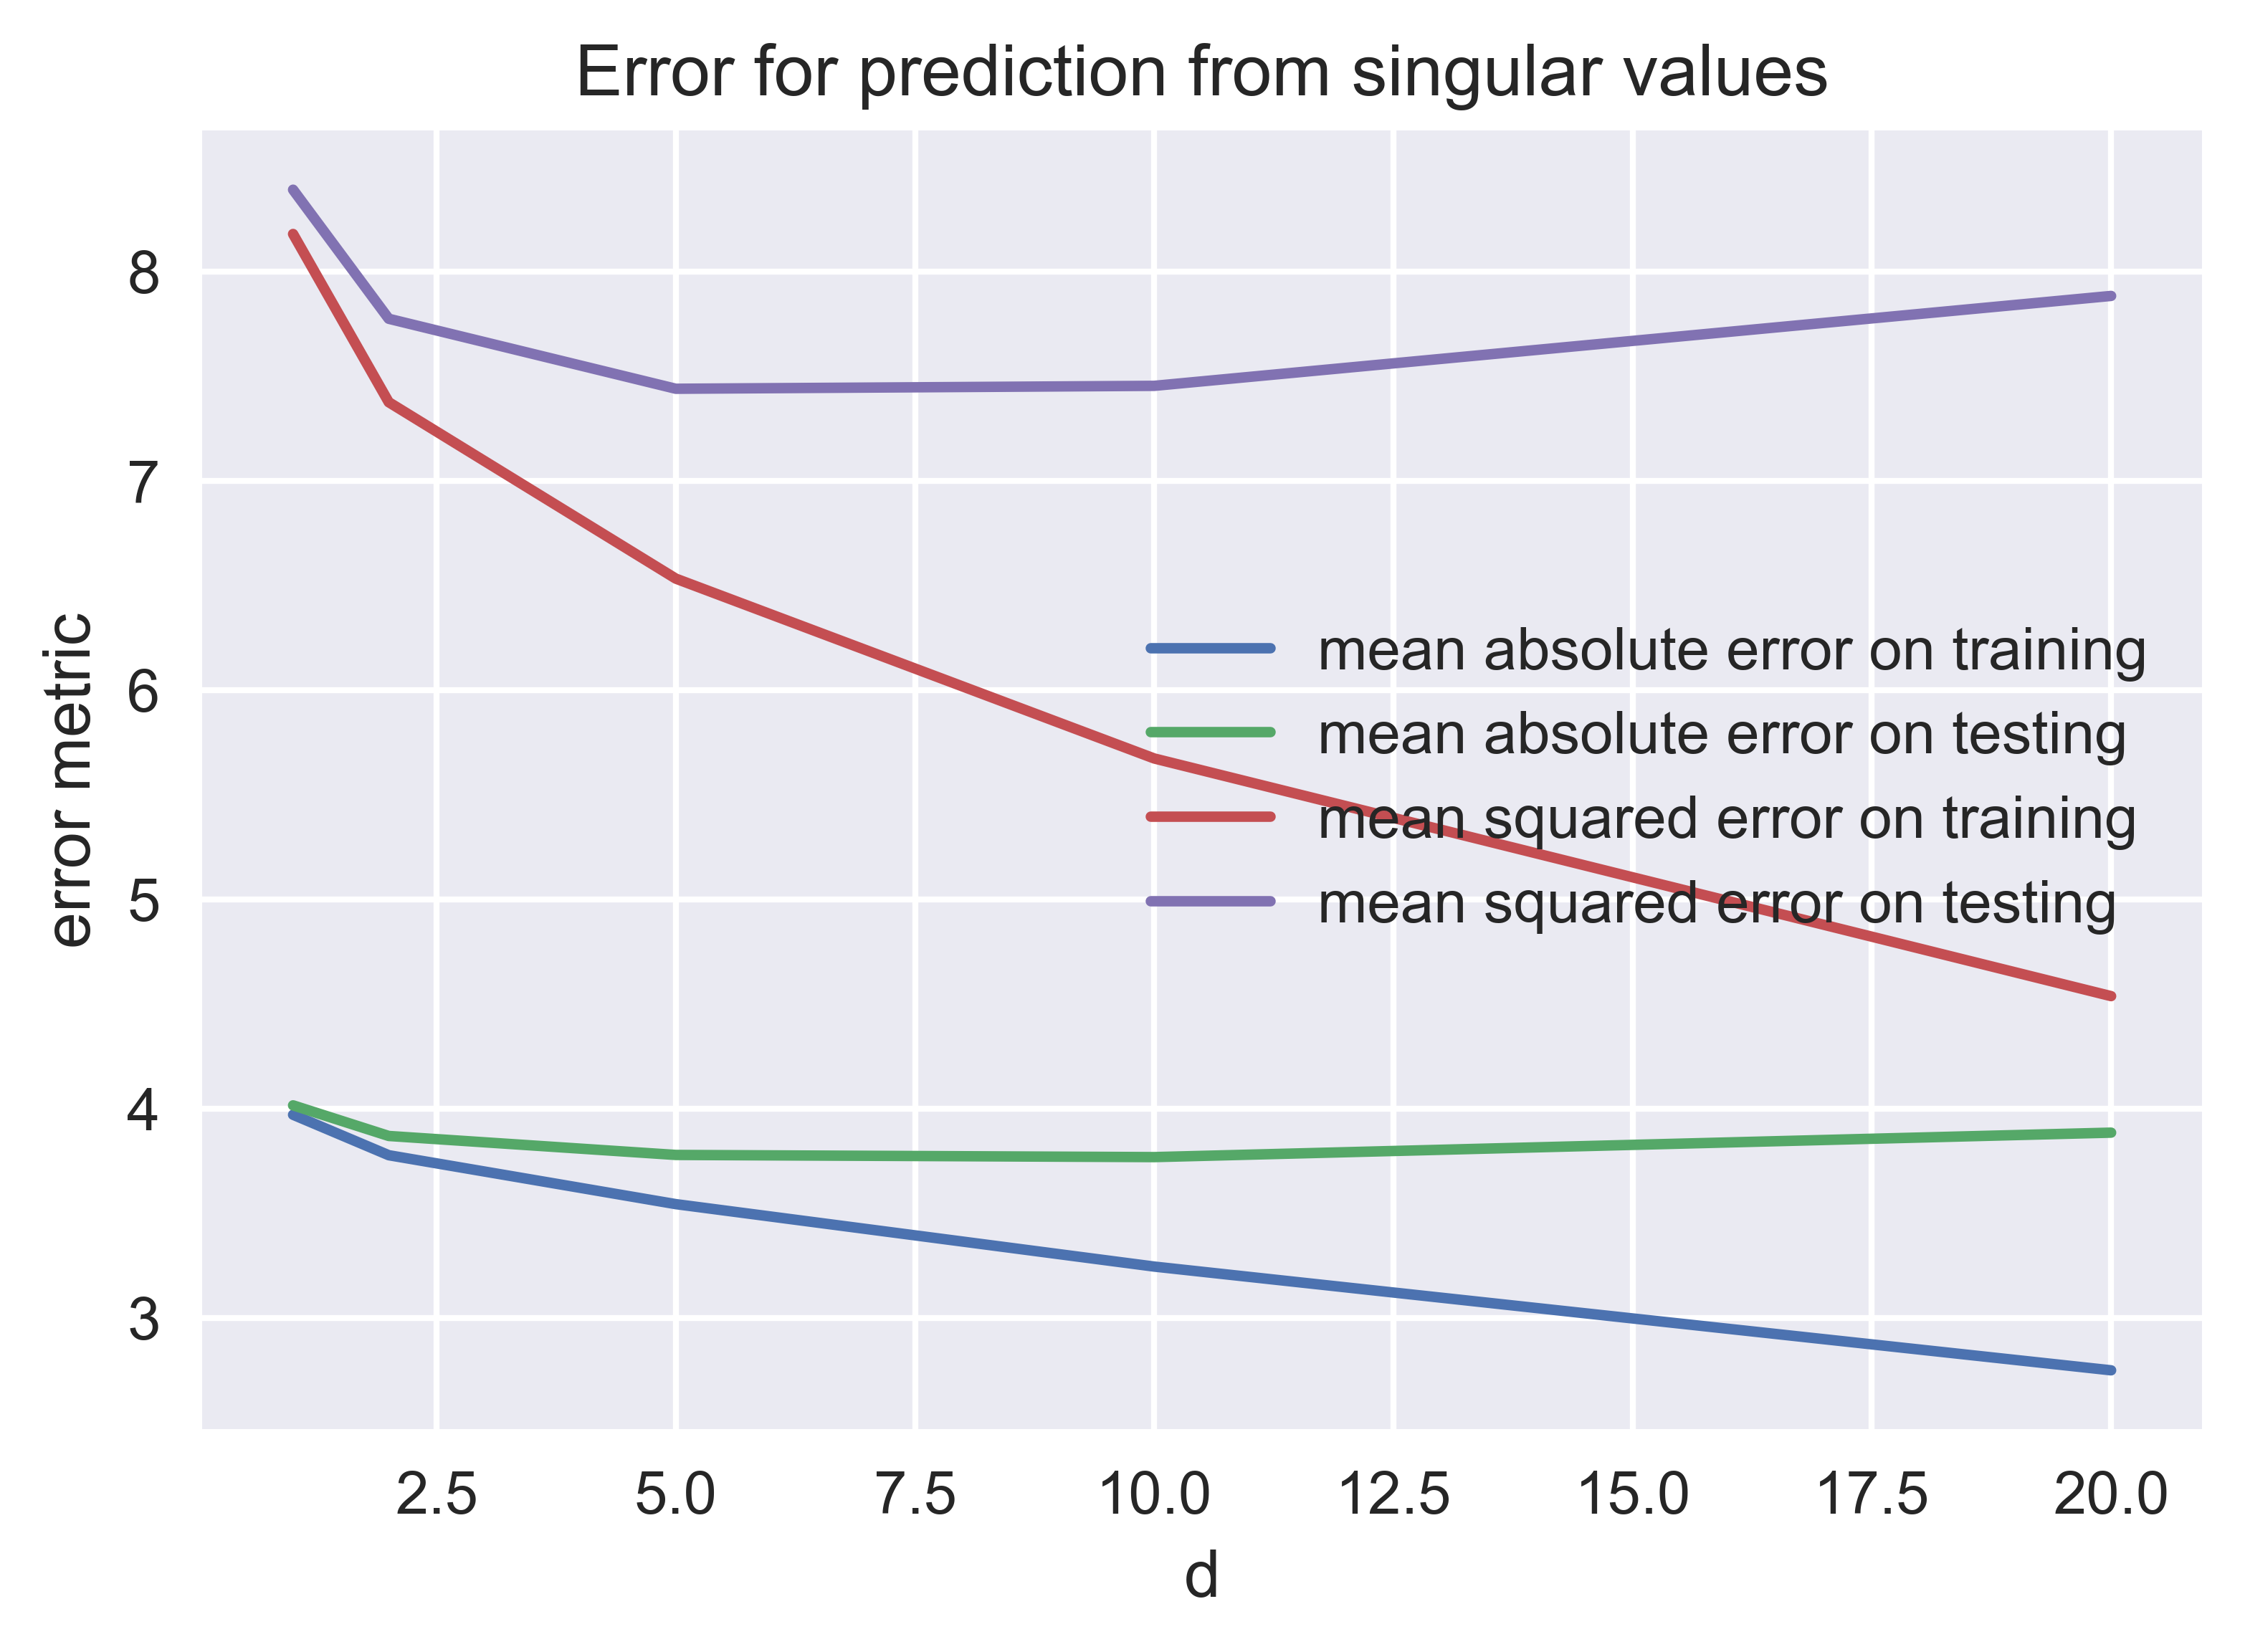

In [231]:
d_vec = [1,2,5,10,20]

mae_training_vec = []
mse_training_vec = []
mae_testing_vec = []
mse_testing_vec = []

avg = False

if avg:
    user_averaged = np.expand_dims(np.mean(training_R_zeros,axis=1),axis=1)

    training_R_zeros_meanSub = training_R_zeros - user_averaged

# use training_R_zeros

for d in d_vec:

    if avg:
        u,s,vt = scipy.sparse.linalg.svds(training_R_zeros_meanSub,k=d)
        R_ij_predict = np.dot(u,np.dot(np.diag(s),vt))
        R_ij_predict = R_ij_predict + user_averaged
    else:
        u,s,vt = scipy.sparse.linalg.svds(training_R_zeros,k=d)
        R_ij_predict = np.dot(u,np.dot(np.diag(s),vt))

    
    mse_test = mean_square_error(R_ij_predict,testing_R)
    print('The mean squared error for using the SVD with d = {} for prediction on the test set is {:.2f}'.format(d,mse_test))
    mae_test = mean_absolute_error(R_ij_predict,testing_R)
    print('The mean absolute error for using the SVD with d = {} for prediction on the test set is {:.2f}'.format(d,mae_test))
    mse_train = mean_square_error(R_ij_predict,training_R)
    print('The mean squared error for using the SVD with d = {} prediction on the train set is {:.2f}'.format(d,mse_train))
    mae_train = mean_absolute_error(R_ij_predict,training_R)
    print('The mean absolute error for using the SVD with d = {} for prediction on the train set is {:.2f}'.format(d,mae_test))
    
    mae_training_vec.append(mae_train)
    mse_training_vec.append(mse_train)
    mae_testing_vec.append(mae_test)
    mse_testing_vec.append(mse_test)
    
plt.figure(dpi=600)
plt.xlabel('d')
plt.ylabel('error metric')
plt.plot(d_vec,mae_training_vec,label='mean absolute error on training')
plt.plot(d_vec,mae_testing_vec,label='mean absolute error on testing')
plt.plot(d_vec,mse_training_vec,label='mean squared error on training')
plt.plot(d_vec,mse_testing_vec,label='mean squared error on testing')
plt.title('Error for prediction from singular values')
plt.legend()

### alternating minimization

### scratch 

In [ ]:
training_user_average = np.mean(training_R_zeros,axis=1)

training_R_no_user_avg = (training_R.T - training_user_average).T